https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
# Einführung in Transfer Learning eines CNN mit Hilfe von pytorch

Original-Einführung von: Sasank Chilamkurthy <https://chsasank.github.io>

In diesem Tutorial erfahren Sie, wie Sie ein bestehendes resnet18-Netzwerk mit Transfer Learning so umtrainieren, dass Sie damit eine neue Klassifizierungsaufgabe erledigen können, d.h. anstatt der Erkennung der ursprünglichen Objektkategorien (Kategorien des ImageNet) kann das umtrainierte Netz nun eigene Objektkategorien unterscheiden und so auf eine neue Aufgabe angewendet werden. Mehr zum Transferlernen erfahren Sie unter cs231n-Notizen <https://cs231n.github.io/transfer-learning/>. Mehr zum Thema Transferlernen mit PyTorch erfahren Sie unter [Finetuning torchvision models](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html).

In diesem Beispiel wollen wir das bestehende Netzwerk umtrainieren, sodass es statt der urpsrünglich 18 Kategorien des resnet18-Netzwerks nun zwei eigene Bildkategorien, nämlich Bienen und Ameisen unterscheiden kann:
<img src="_bees_ants_bees_ants_.png" alt="Example images of bees and ants" />

## Lernziele:
Die Teilnehmenden sind in der Lage
* die Datenorganisation für das Training mit PyTorch zu untersuchen
* den Unterschied zwischen Finetuning und Fixed-Feature-Extractor wiederzugeben
* den Datenaugmenter von PyTorch zu verwenden und das Prinzip des Datenaugmentierens zu erläutern
* ein vortrainiertes Neuronalen Netzes in PyTorch einzulesen und den letzten Layer abzuändern
* ein neuronales Netzes mit PyTorch für eine einfache Klassifikationsaufgabe zu trainieren
* den Trainingserfolg zu bestimmen und zu bewerten
* Hyperparameter des Neuronalen Netzes zu optimieren
* das eingelernte Netzwerks anhand des Test-Sets zu evaluieren, d.h. die Qualität des Netzes zu beurteilen

## Inhalt:
1. [Prinzip des Transfer Lernens](#Prinzip)
2. [Voraussetzungen](#Voraussetzungen)
3. [Daten aufbereiten](#Daten)
  * [Bilddatensätze einlesen](#einlesen)
  * [Data Augmentation und Data Normalization](#Augmentation)  
  
4. [Hilfsfunktionen für Training und Auswahl der Computer-Hardware](#Hilfsfunktionen)
5. [Finetuning (FT) des ConvNet](#Finetuning)
   * [Training des Neuronalen Netzes: model_ft](#Training)
   * [Trainingserfolg anhand des Validation-Set bestimmen](#Trainingserfolg)
6. [ConvNet als Fixed-Feature-Extraktor](#FixedFeatureExtraktor)
   * [Training des Neuronalen Netzes: model_conv](#Training2)
   * [Trainingserfolg anhand des Validation-Set bestimmen](#Trainingserfolg2)


Ein Zitat aus dem obigen Notizen-Link:  
<pre>In der Praxis trainieren nur sehr wenige Menschen ein ganzes Convolutional Neural Netzwerk (CNN oder ConvNet)
von Grund auf (z.B. mit zufälliger Initialisierung sämtlicher Gewichte), da relativ 
selten ein ausreichend grosser Datensatz zu Verfügung steht. 

Stattdessen ist es üblich, ein existierendes ConvNet herunterzuladen, welches bereits auf einen sehr großen Datensatz, wie z.B. ImageNet (mit mehr als 1.2 Millionen Bilder mit 1000 Kategorien) vortrainiert wurde. Dann verwenden wir das vortrainierte ConvNet entweder als Initialisierung oder als fester Merkmals-Extraktor für die neue Transfer-Aufgabe.<pre>


#### Helper-Functions für dieses interactive Tutorial
Mit den in Zelle "In [1]" angegebenen Funktionen werden interaktive Fragen eingeblendet. Sie sind nicht für das Verständnis notwendig, und können übersprungen werden.

In [1]:
from IPython.display import display
import ipywidgets as widgets
import functools
import urllib.parse

def urlcode(text, offset=12, encode=True):
    if encode:
        return(urllib.parse.quote(''.join([chr(ord(ch)+offset) for ch in text])))
    else:
        return(''.join([chr(ord(ch)+offset) for ch in urllib.parse.unquote(text)]))
    
def showSolution(arg,text="button has been clicked!",offset=-12):
    print(urlcode(text, offset, encode=False))
    
def Question(frage, text=None):
    if text is None:
        text = frage;
        frage = 'Antwort anzeigen'
    button_download = widgets.Button(description = frage)   
    button_download.on_click(functools.partial(showSolution, text=text))
    display(button_download)
    
print(urlcode('some garbled text.'))

%7F%7Byq%2Csm~nxqp%2C%C2%80q%C2%84%C2%80%3A


## <a name="Prinzip"></a>Prinzip des Transfer-Lernens

Ein Zitat aus dem obigen Notizen-Link:

<pre>In der Praxis trainieren nur sehr wenige Menschen ein ganzes Convolutional Neural Netzwerk (CNN oder ConvNet)
von Grund auf (z.B. mit zufälliger Initialisierung sämtlicher Gewichte), da relativ 
selten ein ausreichend grosser Datensatz zu Verfügung steht. 

Stattdessen ist es üblich, ein existierendes ConvNet herunterzuladen, welches bereits auf einen sehr großen Datensatz, wie z.B. ImageNet (mit mehr als 1.2 Millionen Bilder mit 1000 Kategorien) vortrainiert wurde. Dann verwenden wir das vortrainierte ConvNet entweder als Initialisierung oder als fester Merkmals-Extraktor für die neue Transfer-Aufgabe.</pre>

Diese beiden großen Transfer-Lernszenarien sehen wie folgt aus:

* **Feinabstimmung des Convnet**: Anstelle einer zufälligen Initialisierung der Gewichte initialisieren wir das Netzwerk mit einem vortrainierten Netzwerk, wie z.B. das auf dem imagenet 1000-Datensatz trainierten Netz. Der Rest des Trainings sieht wie gewohnt aus. Wir beschleunigen damit das Training enorm, denn grosse Teile der Aufgaben (Objektsuche und Objektklassifizierung) werden bereits übernommen.
* **ConvNet als Fixed-Feature-Extraktor**: Hier werden wir die Gewichte für das gesamte Netzwerk mit Ausnahme der letzten, vollständig verbundenen Schicht(en) einfrieren. Diese letzte vollständig verbundene Schicht ist für die eigentliche Klassifizierung verantwortlich, die vorgelagerten Schichten welche für die Objektsuche verantwortlich sind, werden beibehalten. Die Parameter der letzten Schicht werdn dabei durch zufälligen Gewichte ersetzt und nur diese Schicht wird trainiert.

Im Allgemeinen folgen beide Transfer-Lernmethoden den gleichen vier Schritten:

* Initialisieren mit vortrainiertem Modell
* Umgestalten der letzte(n) Ebene(n), sodass am Ausgang die richtige Anzahl von benötigten Klassen vorliegt. (Die Anzahl Eingänge bleibt unverändert)
* Optimierungsalgorithmus definieren: welche Parameter werden während des Trainings aktualisiert
* Training durchführen

## <a name="Voraussetzungen"></a>Voraussetzungen
Führen Sie die folgenden Befehle über die Befehlszeile aus:  
Eventuell verwenden Sie conda oder pip3, dann ersetzen Sie pip durch den entsprechenden Befehl.  
Alternativ finden Sie die Befehle auch auf der [PyTorch-Webseite](https://pytorch.org/).
<pre>pip install --upgrade torch
pip install --upgrade torchvision</pre>

In [2]:
%matplotlib inline

In [3]:
# License: BSD
# Author: Sasank Chilamkurthy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # switch interactive mode 'on'

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.7.1+cpu
Torchvision Version:  0.2.2


## <a name="Daten"></a>Daten aufbereiten
### <a name="einlesen"></a>Bilddatensätze einlesen

.. Hinweis :: Download-Link zum Datensatz: <https://download.pytorch.org/tutorial/hymenoptera_data.zip>_ 
Laden Sie den Datensatz herunter und extrahieren Sie ihn im aktuellen Verzeichnis. So erhalten wir die von PyTorch erwartete Verzeichnisstruktur

<pre>+ \DATA_DIR
   + \train
       + \ants
          - IMAGE1
          - IMAGE2
          - IMAGE3
          - ...
       + \ants
          - IMAGE1
          - IMAGE2
          - IMAGE3
          - ...
   + \val
       + \ants
          - IMAGE1
          - ...
       + \ants
          - IMAGE1
          - ...
</pre>

Wir wollen Bilder von Ameisen und Bienen klassifizieren, dazu haben wir jeweils ca. 120 Trainingsbilder für Ameisen und Bienen. Es bleiben im Datensatz 75 Validierungsbilder für jede Klasse. Normalerweise ist dies ein sehr kleiner Datensatz, mit dem man kein Netz von Grund auf neu trainieren kann. Mit Transfer Learning hingegen, sollten wir in der Lage sein, einigermaßen gute Klassifizierungsergebnisse zu erzielen, d.h. ausgehend vom bestehenden Bildmaterial auch auf andere, unbekannte Bilder zu verallgemeinern.

Dieser Datensatz ist eine sehr kleine Teilmenge von [ImageNet](https://www.image-net.org/).

**Aufgabe:** Machen Sie sich mit der Verzeichnisstruktur der Bilddaten vertraut.  
**Frage:** Woher stammen die für das Training notwendigen Label, bzw. woher kennt PyTorch die Objektklassen?

In [4]:
# Diese Zelle muss zuerst ausgeführt werden, bevor die Lösung angezeigt werden kann:
Question('Puq%2CXmnqx%2C%C2%83q~pqz%2Cmztmzp%2Cpq~%2Cbq~%C2%86quotzu%7F%7F%C2%80~%C2%81w%C2%80%C2%81~%2Cq%C2%84%C2%80~mtuq~%C2%80%3A%16Vqpq%2C%5Bnvqw%C2%80wxm%7F%7Fq%2Ctm%C2%80%2Cquz%2Cqusqzq%7F%2Caz%C2%80q~%C2%82q~%C2%86quotzu%7F8%2Cpq%7F%7Fqz%2CZmyq%2Cmx%7F%2C%5Bnvqw%C2%80wxm%7F%7Fq%2Cpuqz%C2%80%3A%16Puq%2CZmyqz8%2Cp%3At%3A%2Cpuq%2Cbq~%C2%86quotzu%7F%7F%C2%80~%C2%81w%C2%80%C2%81~%2Cy%C4%88%7F%7Fqz%2Cr%C4%88~%2C%60~muzuzs%7F9%2C%C2%81zp%2Cbmxupm%C2%80u%7Bz9_q%C2%80%2Cupqz%C2%80u%7Fot%2C%7Fquz%3A')

Button(description='Antwort anzeigen', style=ButtonStyle())

### <a name="Augmentation"></a>Data Augmentation und Data Normalization
**Data Augmentation**: Um den Datensatz künstlich zu vergrössern, verwenden wir das Prinzip des **Data Augmentation**, d.h. durch geeignete Bildmodifikationen wie z.B. Spiegelung, Vergrössern, Teil-Ausschnitt, etc. werden scheinbar mehr Trainingsdaten zur Verfügung gestellt. Dies geschieht beim Einlesen automatisch durch Verwendung eines *data transformer*.

**Data Normalization**: Beachten Sie, dass die Bilddaten vor dem Trainieren von Netzwerken normalisiert werden, d.h. sämtliche Bilder werden auf bestimmte Mittelwerte $\mu_\text{net}$ und Varianzen $var_\text{net}$ normiert. 

$$\mu = \text{mean}(img), v = \text{var}(img)$$
$$img_\text{new}= \frac{img-\mu}{v}\cdot var_\text{net} + \mu_\text{net}$$

Ausserdem erwartet das vortrainierte Netz Bilddaten einer bestimmten Grösse (In unserem Beispiel: 224 x 224 pixels).
Die Normalisierungswerte für die einzelnen vortrainierten Netzwerke finden Sie [hier](https://pytorch.org/docs/master/torchvision/models.html).

Schliesslich werden für das Training die Bilddaten in sogenannte *Batches* aufgeteilt. Die Grösse eines Batches, d.h. die Anzahl an Bildern die gleichzeitig verarbeitet werden können, hängt von der Computer-Hardware ab. Wir wählen eine Batchgrösse von 4.

Zum Laden, Augmentieren und Normieren der Bilddaten verwenden wir die Pakete *Torchvision* und *Torch.utils.data*.

In [5]:
# Input size = Number of Neurons in Input Layer
input_size = 224

# Batch size for training (change depending on how much memory you have)
batch_size = 4

# Data augmentation, normalization, and resizing for training
# Just resizing and normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size+32),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
# The model here (Resnet18) is expecting the input images to be of certain mean and variance for the Red, Green, Blue channels.
# Mean: Red=0.485, Green=0.456, Blue=0.406, stdRed=0.229, stdGreen=0.225, stdBlue=0.225

data_dir = './hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# Number of classes in the dataset
num_classes = len(class_names)

print("Anzahl Bilder:\n",dataset_sizes)
print("Anzahl Klassen: ",num_classes,"\n", class_names)

Anzahl Bilder:
 {'train': 244, 'val': 153}
Anzahl Klassen:  2 
 ['ants', 'bees']


### Visualisieren der Daten-Modifikationen anhand eines Batches Bilder
Um den Prozess der **Daten-Modifikationen** (Normalisierung, Augmentierung) zu verstehen, lassen wir uns einige Bilder anzeigen:


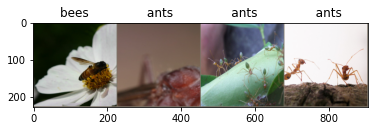

In [6]:
# imshow zeigt Bilder im aktuellen (normalisierten) Format an, macht also die Normierung rückgängig
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1) # datatype float (0,..,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title="               ".join([class_names[x] for x in classes]))

## <a name="Hilfsfunktionen"></a>Hilfsfunktionen für Training und Auswahl der Computer-Hardware
Zunächst soll erkannt werden, welches Hardware-Device zum Training zur Verfügung steht. PyTorch erkennt dies automatisch.

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using hardware device: ", device)

Using hardware device:  cpu


Bevor wir den Code zum Anpassen der Modelle schreiben, definieren wir einige Hilfsfunktionen. 

### Training des Netzwerks (=model) ausgehend von einem existierenden Netzwerk

Wir definieren eine allgemeine Funktion zum Trainieren eines Modells. Hier veranschaulichen wir:

     Verwenden der zur Verfügung stehenden Hardware
     Gebrauch des Schedulers zum Vorgeben der Lernrate
     Abspeichern des besten Modells

Die Trainings-Parameter *criterion*, *optimizer* und *scheduler* werden weiter unten definiert.


In [8]:
# store intermediate results in history dictionary
history_dict = dict({'train_loss':[],'val_loss':[],'train_acc':[],'val_acc':[]})

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    global history_dict
    for key in history_dict:
        history_dict[key] = [];   # initialize, i.e. clear previous results

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'train':
                history_dict['train_loss'].append(epoch_loss)
                history_dict['train_acc'].append(epoch_acc)
            else:
                history_dict['val_loss'].append(epoch_loss)
                history_dict['val_acc'].append(epoch_acc)
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('Elapsed time: {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s  ( = {:.2f}s)'.format(
        time_elapsed // 60, time_elapsed % 60, time_elapsed))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Hilfsfunktion zum Anzeigen der Modell-Vorhersagen

Wir definieren eine Funktion "visualize_model" um einige Bilder samt der vorhergesagten Klassifizierungen anzuzeigen.  
In unserem Datensatz gibt es nur Trainings- und Validation-Bilder, aber keine Test-Bilder, die zur abschliessenden Evaluation der Performance verwendet werden könnten. Wir nehmen stattdessen zur Überprüfung einige Bilder aus dem Validation-Set.

**Frage:** Ist dieses Vorgehen problematisch? Wenn ja, warum?

In [9]:
# Diese Zelle muss zuerst ausgeführt werden, bevor die Lösung angezeigt werden kann:
Question('Pm%7F%2CY%7Bpqxx%2C%C2%83%C2%81~pq%2C%C2%86%C2%83m~%2Czuot%C2%80%2Cmztmzp%2Cpq%7F%2Cbmxupm%C2%80u%7Bz9_q%C2%80%7F%2C%C2%80~muzuq~%C2%808%16mxxq~puzs%7F%2C%C2%83%C2%81~pq%2Cpq~%2CXq~zq~r%7Bxs%2Cyu%C2%80%C2%80qx%7F%2Cbmxupm%C2%80u%7Bz%2C_q%C2%80%2Cnq%7F%C2%80uyy%C2%80%3A%16Mx%7F%7B%2Cu%7F%C2%80%2Cpm%7F%2Cbmxupm%C2%80u%7Bz9_q%C2%80%2Cz%C2%81~%2C%7Fqt~%2Cnqpuzs%C2%80%2Csqquszq%C2%808%16%C2%81y%2Cpuq%2CSqzm%C2%81uswqu%C2%80%2Cpq~%2Cb%7B~tq~%7Fmsqz%2C%C2%86%C2%81%2Cnq%C2%81~%C2%80quxqz%3A')

Button(description='Antwort anzeigen', style=ButtonStyle())

In [10]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## <a name="Finetuning"></a>Finetuning (FT) des ConvNet
Zunächst definieren wir das Modell und die wesentlichen Trainingsparameter

* Einlesen des vortrainierten Modells (*pretrained model*) und Ersetzen des letzten Layers (*reset final fully connected layer*).
* Definieren der Kriterien für das Training
* Definieren des Optimizers für das Training
* Definieren des Schedulers für das Training

Im Folgenden ist der Parameter *scheduler* ein LR-Scheduler-Objekt aus dem Fackel.optim.lr_scheduler.

**Aufgabe:** Versuchen Sie das Grundprinzip des PyTorch LR-Scheduler zu verstehen (Internet-Recherche).  
Sie sollen nicht im Detail verstehen, wie der Scheduler funktioniert, sondern nur was dadurch optimiert wird wird.  
**Frage:** Wofür steht "LR" im Begriff LR-Scheduler?

In [11]:
# Diese Zelle muss zuerst ausgeführt werden, bevor die Lösung angezeigt werden kann:
Question('X%5E%2C%7F%C2%80qt%C2%80%2Cr%C4%88~%2CXqm~zuzs%2C%5Em%C2%80q8%2Cmx%7F%7B%2Cpuq%2CXq~z~m%C2%80q%3A')

Button(description='Antwort anzeigen', style=ButtonStyle())

In [12]:
model_ft = models.resnet18(pretrained=True) # Load model including pretrained weights

# output original final layer:
print("Original final layer: ", model_ft.fc)

# replace final layer with a new layer:
# Here the size of each output sample is set to num_classes (=2).
num_ftrs = model_ft.fc.in_features   # extract number of inputs in original final layer
model_ft.fc = nn.Linear(num_ftrs, num_classes) # generate new final layer with number of inputs and outputs
print("Modified final layer: ", model_ft.fc)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Original final layer:  Linear(in_features=512, out_features=1000, bias=True)
Modified final layer:  Linear(in_features=512, out_features=2, bias=True)


**Aufgabe:** Was ist "resnet18"? (Internet-Recherche)  
**Frage:** Wie viele Layer hat das resnet18 Netzwerk? 

In [13]:
# Diese Zelle muss zuerst ausgeführt werden, bevor die Lösung angezeigt werden kann:
Question('Anzahl Layer','Pm%7F%2C%5Eq%7FZq%C2%809%3DD%2CY%7Bpqxx%2Ctm%C2%80%2C%3DD%2CXm%C2%85q~%3A')

Button(description='Anzahl Layer', style=ButtonStyle())

**Aufgabe:** Gehen Sie auf die Seite der [PyTorch Modelle](https://pytorch.org/vision/stable/models.html).  
**Frage:** Welche Modelle haben Anforderungen hinsichtlich der Grösse der Eingangsbilddaten?  
Gibt es für das ResNet-18 Modell hierzu Informationen auf der PyTorch Webseite?

In [14]:
# Diese Zelle muss zuerst ausgeführt werden, bevor die Lösung angezeigt werden kann:
Question('M%C2%81r%2Cpq~%2C%5C%C2%85%60%7B~ot9cqn%7Fqu%C2%80q%2Csun%C2%80%2Cq%7F%2Cpm%C2%86%C2%81%2Cwquzq%2CUzr%7B%7F%3A%16Q%7F%2Cw%C4%82zzqz%2C%C2%81z%C2%80q~%7Fotuqpxuotq%2Cs~%7B%7F%7Fq%2CNuxppm%C2%80qz%2Cquzsqr%C4%88%C2%80%C2%80q~%C2%80%2C%C2%83q~pqz%3A')

Button(description='Antwort anzeigen', style=ButtonStyle())

**Aufgabe:** Zeigen Sie die ersten Layer des Resnet18-Netzwerk an: <pre>print(model_ft.layer1)</pre>
**Frage:** Welche Layer-Typen können Sie erkennen?

In [15]:
print(model_ft.layer1)

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)


### <a name="Training"></a>Training des Neuronalen Netzes (Mode: Finetuning)

Im Finetuning-Modus wurde zwar nur die letzte Schicht (classification layer) des Neuronalen Netzes ersetzt, aber es wird das gesamte Netz auf die neue Aufgabe umtrainiert.  
Auf der CPU sollte das Training etwa 30 Minuten dauern. Auf der GPU dauert es typischerweise weniger als eine Minute. 

In [16]:
print("Start training (Finetuning Mode). Please wait ...")
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Start training (Finetuning Mode). Please wait ...
Epoch 0/24
----------
train Loss: 0.5363 Acc: 0.7295
val Loss: 0.2799 Acc: 0.8693
Elapsed time: 1m 18s

Epoch 1/24
----------
train Loss: 0.4974 Acc: 0.7951
val Loss: 0.2462 Acc: 0.9020
Elapsed time: 2m 28s

Epoch 2/24
----------
train Loss: 0.4553 Acc: 0.8074
val Loss: 0.3111 Acc: 0.8431
Elapsed time: 3m 42s

Epoch 3/24
----------
train Loss: 0.4243 Acc: 0.8320
val Loss: 0.2524 Acc: 0.9346
Elapsed time: 4m 49s

Epoch 4/24
----------
train Loss: 0.4473 Acc: 0.8320
val Loss: 0.2014 Acc: 0.9346
Elapsed time: 5m 58s

Epoch 5/24
----------
train Loss: 0.6549 Acc: 0.7582
val Loss: 0.3294 Acc: 0.8889
Elapsed time: 7m 10s

Epoch 6/24
----------
train Loss: 0.5654 Acc: 0.7828
val Loss: 0.3501 Acc: 0.8497
Elapsed time: 8m 18s

Epoch 7/24
----------
train Loss: 0.4097 Acc: 0.8320
val Loss: 0.3213 Acc: 0.8824
Elapsed time: 9m 33s

Epoch 8/24
----------
train Loss: 0.2774 Acc: 0.8852
val Loss: 0.2820 Acc: 0.8824
Elapsed time: 10m 55s

Epoch 9/24
--

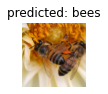

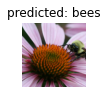

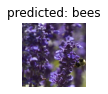

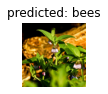

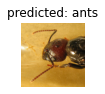

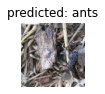

In [17]:
# Anzeige einiger Beispielbilder a
visualize_model(model_ft)

### <a name="Trainingserfolg"></a>Trainingserfolg bestimmen

Wir vergleichen nun die Resultate auf dem Trainings- und dem Validation-Set.  
Zur Anzeige der Ergebnisse benötigen wir noch eine Hilfsfunktion showResults:


In [18]:
# Hilfsfunktion, um die Ergebnisse anzuzeigen
def showResults(mode):
    global history_dict
    epochs = range(1, len(history_dict['train_acc']) + 1)
    plt.figure(figsize=(10, 7))
    if mode == 'loss':
        plt.plot(epochs, history_dict['train_loss'], 'bo', label='Training loss')
        plt.plot(epochs, history_dict['val_loss'], 'b', label='Validation loss')
        plt.title('Training and Validation Loss')
        plt.ylabel('Loss')
    else:
        plt.plot(epochs, history_dict['train_acc'], 'bo', label='Training acc')
        plt.plot(epochs, history_dict['val_acc'], 'b', label='Validation acc')
        plt.title('Training and Validation Accuracy')
        plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.grid()
    plt.legend()
    plt.show()

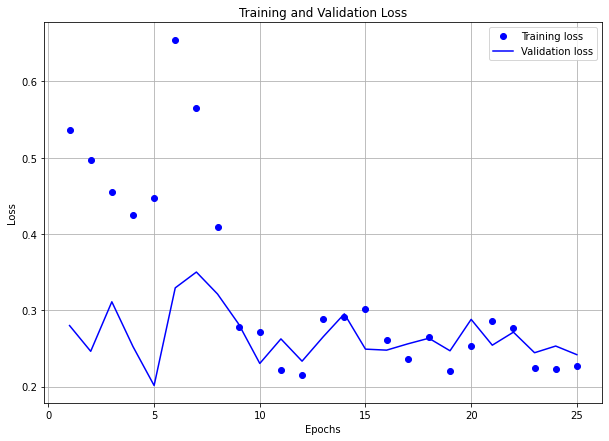

In [19]:
# Training und Validation loss anzeigen
showResults('loss')

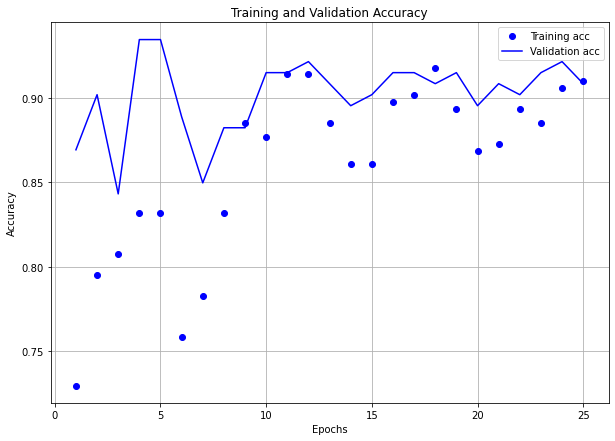

final validation_acc: tensor(0.9085, dtype=torch.float64)


In [20]:
# Training und validation accuracy anzeigen
showResults('acc')
print('final validation_acc:', history_dict['val_acc'][-1])

##  <a name="FixedFeatureExtraktor"></a>ConvNet als Fixed-Feature-Extraktor

Hier müssen wir die Gewichte für das gesamte Netzwerk ausser der letzten Ebene einfrieren.  
Wir müssen require_grad == False setzen, um die Parameter einzufrieren; damit werden die Gradienten in backward() nicht berechnet, und das Training läuft wesentlich schneller ab.

Mehr Informationen dazu finden Sie in der Dokumentation hier <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>.


In [21]:
model_conv = torchvision.models.resnet18(pretrained=True) # Load model including pretrained weights
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### <a name="Training2"></a>Training des Neuronalen Netzes (als Fixed-Feature-Extraktor)

Auf der CPU dauert dies kürzer wie im vorherigen Szenario. Dies wird erwartet, da für den größten Teil des Netzwerks keine Gradienten berechnet werden müssen. forward() muss jedoch berechnet werden. 

In [22]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.8021 Acc: 0.5533
val Loss: 0.3701 Acc: 0.8170
Elapsed time: 0m 37s

Epoch 1/24
----------
train Loss: 0.6984 Acc: 0.6926
val Loss: 0.6048 Acc: 0.7582
Elapsed time: 1m 13s

Epoch 2/24
----------
train Loss: 0.5899 Acc: 0.7705
val Loss: 0.2110 Acc: 0.9412
Elapsed time: 1m 45s

Epoch 3/24
----------
train Loss: 0.4989 Acc: 0.7992
val Loss: 0.2250 Acc: 0.9150
Elapsed time: 2m 20s

Epoch 4/24
----------
train Loss: 0.4520 Acc: 0.8074
val Loss: 0.3032 Acc: 0.8954
Elapsed time: 2m 57s

Epoch 5/24
----------
train Loss: 0.2787 Acc: 0.8811
val Loss: 0.1805 Acc: 0.9412
Elapsed time: 3m 29s

Epoch 6/24
----------
train Loss: 0.2874 Acc: 0.8934
val Loss: 0.2201 Acc: 0.9281
Elapsed time: 4m 3s

Epoch 7/24
----------
train Loss: 0.3983 Acc: 0.8197
val Loss: 0.1643 Acc: 0.9477
Elapsed time: 4m 37s

Epoch 8/24
----------
train Loss: 0.4203 Acc: 0.8197
val Loss: 0.1711 Acc: 0.9412
Elapsed time: 5m 12s

Epoch 9/24
----------
train Loss: 0.3990 Acc: 0.8402
val Loss: 0.

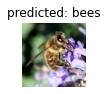

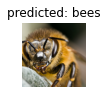

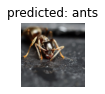

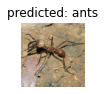

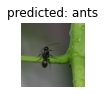

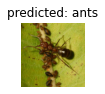

In [23]:
visualize_model(model_conv)

plt.ioff()
plt.show()

**Frage:** Um wieviel schneller läuft das Trainnig ab?

In [24]:
# Bitte hier die Trainingsdauern aus den Abschnitten "Training des Neuronalen Netzes (Mode: Finetuning)"
# bzw. "Training des Neuronalen Netzes (Mode: Fixed-Feature-Extractor)" eintragen:
ratio_training_times = 1763.96/819.64; # <== Bitte die Werte aus den Trainings entnehmen.
print("Das Training läuft {:.2f} mal schneller ab.".format(ratio_training_times))

Das Training läuft 2.15 mal schneller ab.


### <a name="Trainingserfolg2"></a>Trainingserfolg beim Fixed-Feature-Extractor-Mode bestimmen

Wir vergleichen nun die Resultate beim Trainieren des Neuronalen Netzes als Fixed-Feature-Extractor.
Wiederum zeigen wir die Loss- und Accuracy-Kurven für Trainings- und Validation-Set an.  
Zur Anzeige der Ergebnisse verwenden wir wieder die Funktion showResults:


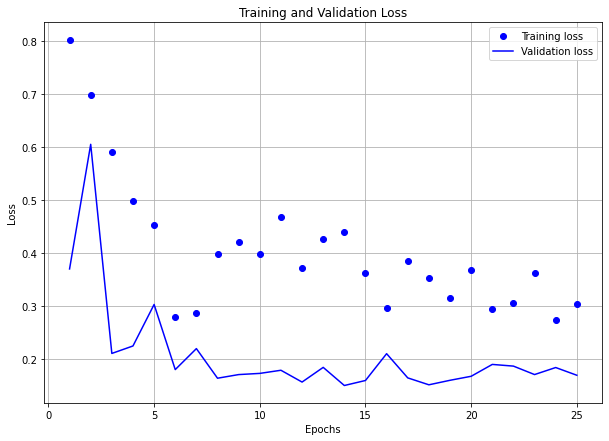

In [25]:
# Training und Validation loss anzeigen
showResults('loss')

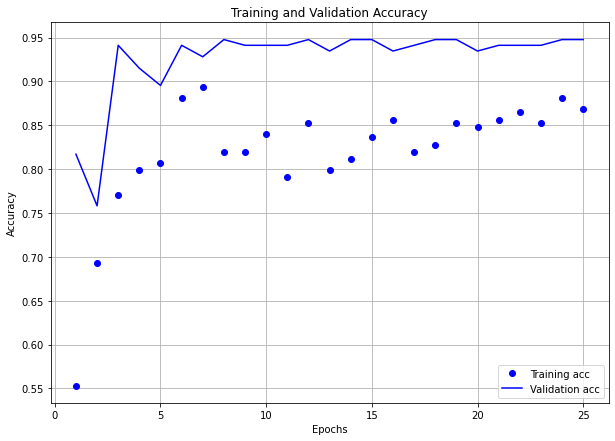

final validation_acc: tensor(0.9477, dtype=torch.float64)


In [26]:
# Training und validation accuracy anzeigen
showResults('acc')
print('final validation_acc:', history_dict['val_acc'][-1])

**Frage**: Wie sieht es mit der Vorhersage-Genauigkeit des Netzes aus?  
Vergleichen Sie den Wert beim Trainieren im Finetunig-Mode (model_ft) mit dem Wert,  
den Sie beim Trainieren als Fixed-Feature-Extractor (model_conv) erhalten haben.  
Weshalb sind die Werte so gut, bzw. weichen voneinander ab?

In [27]:
Question('Pm%7F%2C%5B~usuzmx9Y%7Bpqxx%2C%C2%83%C2%81~pq%2Cnq~qu%C2%80%7F%2Cyu%C2%80%2CNuxpq~z%2C%C2%82%7Bz%2CNuqzqz%2C%C2%81zp%2CMyqu%7Fqz%2C%C2%80~muzuq~%C2%808%16pq%7Ftmxn%2C%7Fuzp%2Cpuq%2CQ~sqnzu%7F%7Fq%2Cuz%7Fsq%7Fmy%C2%80%2C%7Fqt~%2Cs%C2%81%C2%808%2Cpm%2Cpuq%2CQ~wqzz%C2%81zs%2C%7Fot%7Bz%2C%C2%86%C2%81%C2%82%7B~%2Csqsqnqz%2C%C2%83m~%3A%16Mxxq~puzs%7F%2C%C2%83%C2%81~pq%2Cnquy%2CRu%C2%84qp9Rqm%C2%80%C2%81~q9_q%C2%80%2Cz%C2%81~%2Cpq~%2Cxq%C2%80%C2%86%C2%80q%2CXm%C2%85q~%2Cmw%C2%80%C2%81mxu%7Fuq~%C2%808%16%7C~mw%C2%80u%7Fot%2Cmx%7F%7B%2Cz%C2%81~%2Cpuq%2C%C4%88nq~rx%C4%88%7F%7Fusqz8%2Czuot%C2%80%2Cnqz%C2%81%C2%80%C2%86%C2%80qz%2CM%C2%81%7Fs%C3%B0zsq%2Cqz%C2%80rq~z%C2%80%3A%16Tuzsqsqz%2Cu%7F%C2%80%2Cnquy%2CRuzq%C2%80%C2%81zuzs%2Cpm%7F%2Csmz%C2%86q%2CZq%C2%80%C2%86%2C%C2%82q~%C3%B0zpq~%C2%80%2C%C2%83%7B~pqz8%16x%7Bsu%7Fotq~%C2%83qu%7Fq%2Cu%7F%C2%80%2Cpm%7F%2C%60~muzuzs%7F9Q~sqnzu%7F%2Cq%C2%80%C2%83m%7F%2C%7Fotxqot%C2%80q~%3A')

Button(description='Antwort anzeigen', style=ButtonStyle())